In [1]:
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline 
import fipy as fp

In [2]:
#%% Space discretisation 
nr = 50 # Number of cells in the radial direction
nz = 100 # Number of cells in the vertical direction
L_r = 2e-3 # [m] Domain length in the radial direction
dr = L_r / nr 
mesh = fp.CylindricalGrid1D(nr=nr, dr=dr) # Define cylindrical structured grid
#%% Time discretisation
t_final = 30 # Define simulation time [s]
timeStepDuration = 0.1 # Define time step [s]
steps = int(t_final / timeStepDuration) # Define number of steps [.]
tps = np.linspace(0,t_final,steps)

In [3]:
#%% Create Initial Condition array 
Ti = 20 + 273.15 # [K] Temperature initiale
Te = 100 + 273.15 # [K] Temperature de l'eau (thermostat)
Tc_1 = 75 + 273.15 # [K] Temperature finale desiree pour le spaghetti cas 1
Tc_2 = 90 + 273.15 # [K] Temperature finale desiree pour le spaghetti cas 2
h = 0.01 # [W.K^-1] coefficient de convection eau/spaghetti
lambd = 0.16 # [W.m^-1.K^-1] conductivite thermique du spaghetti 
c = 2.9 # [J.kg^-1.K^-1] capacite thermique massique du spaghetti 
rho = 0.75*10**(3)# [kg.m^-3] masse volumique du spaghetti
D = lambd /(rho*c) # [m^2.s^-1] coefficient de diffusion [m^2/s]
T_init = Ti + np.zeros((nr))

In [4]:
#%% Initialisation of Solution Object (CellVariable)
T = fp.CellVariable(name = "T[K]", mesh =mesh, value =T_init)

/Users/cyrille/opt/anaconda3/lib/python3.8/site-packages/fipy/viewers/matplotlibViewer/__init__.py:120: UserWarning: Matplotlib1DViewer efficiency is improved by setting the 'datamax' and 'datamin' keys
  return Matplotlib1DViewer(vars=vars, title=title, axes=axes, **kwlimits)


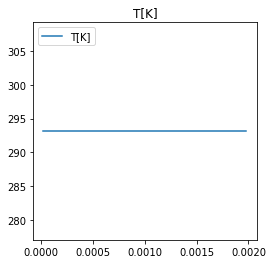

In [5]:
#%% Affichage de la temperature initiale dans le spaghetti
viewer = fp.Viewer(vars=T)
viewer.plotMesh()

In [6]:
T.faceGrad.constrain([(Te - T.faceValue)*h/lambd], 
                     mesh.exteriorFaces) # (dT/dr) = (Tc - T)*h/lambda on exterior faces

#X,Y = mesh.faceCenters
#T.constrain(Te, mesh.exteriorFaces)
#%% Define PDE
eq = fp.TransientTerm() - fp.DiffusionTerm(coeff=D) == 0


In [7]:
#%% Solve Diffusion Equation via FVM 
T_sol = np.zeros((nr,steps)) # Initialise solution vector
T_sol[:,0] = T.value # Add the initial concentraton to thesolution vector
for step in range(steps):
    eq.solve(var=T, dt=timeStepDuration)
    T_sol[:,step]=T.value

/Users/cyrille/opt/anaconda3/lib/python3.8/site-packages/fipy/viewers/matplotlibViewer/__init__.py:120: UserWarning: Matplotlib1DViewer efficiency is improved by setting the 'datamax' and 'datamin' keys
  return Matplotlib1DViewer(vars=vars, title=title, axes=axes, **kwlimits)


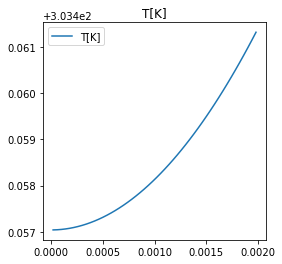

In [8]:
#viewer = fp.Viewer(vars=T)
#viewer.plotMesh()


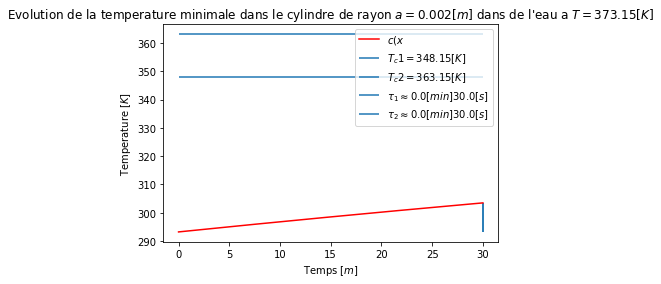

In [9]:
T_min = np.amin(T_sol, axis=0)
tau1 = sorted(zip(tps,T_min), key = lambda x : abs(x[1] - (Tc_1)))[0][0]
tau2 = sorted(zip(tps,T_min), key = lambda x : abs(x[1] - (Tc_2)))[0][0]
plt.figure(1)
plt.clf()
plt.plot(tps,T_min, 'r',label = "$c(x$")
plt.hlines(y= Tc_1,xmin=0, xmax=tps[-1],label=f"$T_c1 = {Tc_1}[K]$")
plt.hlines(y= Tc_2,xmin=0, xmax=tps[-1],label=f"$T_c2 = {Tc_2}[K]$")
plt.vlines(x=tau1, ymin=min(T_min), ymax = max(T_min),label =f"$\\tau_1 \\approx {tau1 //60}[min] {round(tau1%60)}[s]$")
plt.vlines(x=tau2, ymin=min(T_min), ymax = max(T_min),label =f"$\\tau_2 \\approx {tau2 //60}[min] {round(tau2%60)}[s]$")
plt.title(f"Evolution de la temperature minimale dans le cylindre de rayon $a = {L_r} [m]$ dans de l'eau a $T = {Te} [K]$")
plt.xlabel('Temps $[m]$')
plt.ylabel('Temperature $[K]$')
plt.legend()

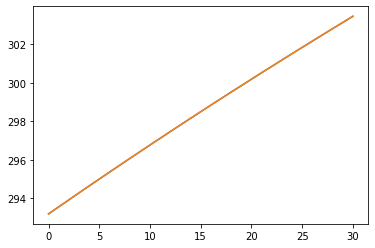

In [10]:
plt.plot(tps,T_sol[0,:])
plt.plot(tps,T_sol[-1,:])

In [11]:
T_sol

array([[293.18439154, 293.22105157, 293.25779539, ..., 303.39291542,
        303.42498668, 303.4570432 ],
       [293.18439528, 293.22105555, 293.25779939, ..., 303.39291891,
        303.42499017, 303.45704668],
       [293.18440276, 293.22106353, 293.25780738, ..., 303.39292589,
        303.42499715, 303.45705366],
       ...,
       [293.18874139, 293.22555551, 293.26230297, ..., 303.39685136,
        303.42892081, 303.46097552],
       [293.18893239, 293.2257474 , 293.26249479, ..., 303.39701884,
        303.42908822, 303.46114285],
       [293.18912787, 293.22594329, 293.26269061, ..., 303.39718982,
        303.42925911, 303.46131366]])

In [12]:
min(T_sol[:,-10]),max(T_sol[:,10])

(303.1680031755789, 293.55604784404966)

In [13]:
np.shape(T_sol)

(50, 300)